In [1]:
import argparse
from itertools import product as iterprod
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from argparse import ArgumentParser
import time
from datetime import datetime
from tqdm.autonotebook import tqdm
import pandas as pd

import matplotlib.pyplot as plt



/tmp/ipykernel_177346/3724148964.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import utils.data67_processing as dp


from utils.UNeXt import UNet
from utils.loss_inference import loss_function_dict

import utils.nb_utils as nb_utils

import pprint

np.random.seed(11) # for reproducibility
torch.manual_seed(11)


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
batch_size = 8
num_workers = 4

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pin_memory = True if torch.cuda.is_available() else False

In [4]:
device


device(type='cuda', index=0)

# Build dataset

In [4]:
# Dataset
directory  = '/net/projects/CLS/force_reference/data/TractionData_27_04_21_ZyxinPaxillin/'
# directory  = '/net/projects/CLS/force_reference/data/ZyxAct_16kPa_small/'

test_cells = 'cell_1'


in_channels  = [[6]] # Example: [[4], [4,6], [4,6,7]]. Channel 4 is mask, 6 is zyxin, 7 is other protein (here actin)
out_channels = (7)
transform_kwargs = {'crop_size': 512,
                    'output_channels': out_channels,
                    'norm_output': {'rescale': 0.25, 'threshold': 0.4}
                    }

dataset_kwargs = { 
                    'root': directory,
                    'force_load': False,
                    'test_split': 'bycell',
                    'test_cells': test_cells,
                    'in_channels': in_channels, 
                    'out_channels': out_channels, 
                    'transform_kwargs': transform_kwargs,
                    'frames_to_keep': 256,
                    'input_baseline_normalization': 'outside_inside', # Comment on what these do
                    'output_baseline_normalization': 'mean_dataset',
                    'remake_dataset_csv': True
                     }


dataset = dp.CellDataset( **dataset_kwargs )

train_loader = dataset.get_loader(dataset.train_indices, batch_size, num_workers, pin_memory)
validation_loader = dataset.get_loader(dataset.test_indices, batch_size, num_workers, pin_memory)

In [5]:
dataset

# Some visualizations of the training data

The dataset class gets items by looking into a dataframe (`dataset.info`) where the folders and filenames are stored. Folders correspond to single cells, and each file is a frame of the time series. 

`dataset.info` contains the normalization values which the data is normalized by before it is passed to the NN. Forces are normalized by `dataset.info.F_mean` and the zyxin signal is normalized by `dataset.info.zyxin_baseline_out` and `dataset.info.zyxin_baseline_in`. Details about how these are generated can be found in the DataProcessing notebook.
    


In [6]:
df = dataset.info.copy()

df.head(10)

,folder,filename,frame,root,zyxin_baseline,actin_baseline,zyxin_baseline_out,zyxin_baseline_in,actin_baseline_out,actin_baseline_in
0,cell_5,Disp_Trac_CellMask_ForceMask_Actin_0.npy,0,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109
1,cell_5,Disp_Trac_CellMask_ForceMask_Actin_1.npy,1,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109
2,cell_5,Disp_Trac_CellMask_ForceMask_Actin_2.npy,2,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109
3,cell_5,Disp_Trac_CellMask_ForceMask_Actin_3.npy,3,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109
4,cell_5,Disp_Trac_CellMask_ForceMask_Actin_4.npy,4,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109
5,cell_5,Disp_Trac_CellMask_ForceMask_Actin_5.npy,5,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109
6,cell_5,Disp_Trac_CellMask_ForceMask_Actin_6.npy,6,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109
7,cell_5,Disp_Trac_CellMask_ForceMask_Actin_7.npy,7,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109
8,cell_5,Disp_Trac_CellMask_ForceMask_Actin_8.npy,8,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109
9,cell_5,Disp_Trac_CellMask_ForceMask_Actin_9.npy,9,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.39028,86.818317,10.747155,25.830109


In [7]:
# Print test cells: 
print(dataset.test_cells)
print(dataset.test_indices)

{'test_cells': ['cell_1']}
[415 364 448 476 403 450 423 431 387 404 436 380 416 439 413 405 378 420
 388 442 456 385 478 470 381 390 418 374 372 445 463 462 428 409 432 399
 392 453 482 433 402 406 479 398 386 468 467 430 422 427 446]


In [8]:
dataset.info

,folder,filename,frame,root,zyxin_baseline,actin_baseline,zyxin_baseline_out,zyxin_baseline_in,actin_baseline_out,actin_baseline_in
0,cell_5,Disp_Trac_CellMask_ForceMask_Actin_0.npy,0,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.390280,86.818317,10.747155,25.830109
1,cell_5,Disp_Trac_CellMask_ForceMask_Actin_1.npy,1,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.390280,86.818317,10.747155,25.830109
2,cell_5,Disp_Trac_CellMask_ForceMask_Actin_2.npy,2,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.390280,86.818317,10.747155,25.830109
3,cell_5,Disp_Trac_CellMask_ForceMask_Actin_3.npy,3,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.390280,86.818317,10.747155,25.830109
4,cell_5,Disp_Trac_CellMask_ForceMask_Actin_4.npy,4,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,13.390280,86.818317,10.747155,25.830109
...,...,...,...,...,...,...,...,...,...,...
479,cell_1,Disp_Trac_CellMask_ForceMask_Actin_116.npy,116,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,10.708059,127.223836,5.975600,36.764299
480,cell_1,Disp_Trac_CellMask_ForceMask_Actin_117.npy,117,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,10.708059,127.223836,5.975600,36.764299
481,cell_1,Disp_Trac_CellMask_ForceMask_Actin_118.npy,118,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,10.708059,127.223836,5.975600,36.764299
482,cell_1,Disp_Trac_CellMask_ForceMask_Actin_119.npy,119,/net/projects/CLS/force_reference/data/Tractio...,0.0,0.0,10.708059,127.223836,5.975600,36.764299


In [9]:
cell = 'cell_1'
frame = 5

idx = dataset.info.index[(dataset.info.folder==cell)&(dataset.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.
print(idx)

368


In [10]:
dataset.out_channels


7

In [11]:
sample = dataset[idx]

{'mask': torch.Size([1, 512, 512]), 'zyxin': torch.Size([1, 512, 512]), 'actin': torch.Size([1, 512, 512]), 'output': torch.Size([1, 512, 512])}


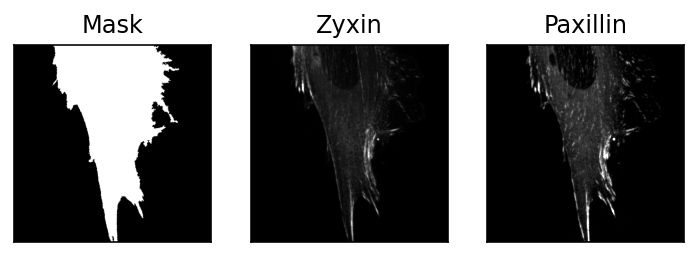

In [17]:
fig,ax=plt.subplots(1,3,figsize=(2*3, 4*2), dpi=144)


print({key: sample[key].shape for key in sample.keys()})

ax[0].set_title('Mask')
ax[0].imshow(sample['mask'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[1].set_title('Zyxin')
ax[1].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=10, vmin=0)
ax[2].set_title('Paxillin')
ax[2].imshow(sample['output'][0,:,:].squeeze(), origin='lower', cmap='gray', vmax=10, vmin=0)


for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

In [18]:
sample

{'mask': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'zyxin': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'actin': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'output': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0.

# Build U-Net model with ConvNext blocks

In [26]:
n_lyr  = 3 # number of downsampling layers
ds_krnl= 4 # downsample kernel
n_ch   = 4 # number of channels in the beginning of the network
n_blocks = 4 # number of ConvNext blocks, wherever ConvNext blocks are used

prepend_hparams = {'start_channel': 1, 'resnet_channel': n_ch, 'end_channel': n_ch, 'N_blocks': n_blocks,                                         # Args for architecture
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} # Args for ConvNext blocks
encoder_hparams = {'n_ch': n_ch, 'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'N_skip_blocks': n_blocks,
                    'downsample_kwargs': {'kernel': ds_krnl, 'activation': 'gelu', 'batchnorm': 1},
                    'interlayer_kwargs': {'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
                    }
decoder_hparams = {'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'upsample_kernel': ds_krnl,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
append_hparams = {'start_channel': n_ch, 'resnet_channel': n_ch, 'end_channel': 2, 'N_blocks': n_blocks,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 8, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} 
optimizer_hparams = {'LR': 0.001, 'schedule_rate': 0.99}
loss_hparams = {'loss_type': 'r_mse',
                'exp_weight': 0.0,
                'strainenergy_regularization': 0.0,
                'exp_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'reg_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'loss_kwargs': {'max_force': 8.}
               }





models = {}
for protein in ['zyxin1','zyxin2']:
    modelname = 'model_z2p_150ep'

    logger_params = {'log_dir': f'./tensorboard_logs/{modelname}', 
                     'image_epoch_freq': 10,
                     'image_callbacks': 'vectorfield,hists',
                     'save_model_freq': 4}

    # Actually build model:
    model_kwargs={
                    'input_type':  protein[:-1], 
                    'prepend_hparams': prepend_hparams, 
                    'encoder_hparams': encoder_hparams, 
                    'decoder_hparams': decoder_hparams, 
                    'append_hparams': append_hparams, 
                    'optimizer_hparams': optimizer_hparams,
                    'loss_hparams': loss_hparams,
                    'logger_params': logger_params,
                    'name': 'model_0'}


    model = UNet( **model_kwargs, model_idx=0)
    model.to(device)
    
    models[protein] = model


In [27]:
models

{'zyxin1': UNet(
   (layers_encode): ModuleList(
     (0): ModuleList(
       (0-3): 4 x ConvNextCell(
         (conv0): Conv2d(4, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=4)
         (conv1): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))
         (conv2): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1))
         (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (act): GELU(approximate='none')
       )
       (4): DownsampleLayer(
         (conv): Conv2d(4, 8, kernel_size=(4, 4), stride=(4, 4))
         (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (act): GELU(approximate='none')
       )
     )
     (1): ModuleList(
       (0-3): 4 x ConvNextCell(
         (conv0): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=8)
         (conv1): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
         (conv2): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
  

In [28]:
protein[:-1]

'zyxin'

# Perform training

In [29]:
save_models = True
n_epochs = 150

pbar = tqdm(total=n_epochs*(np.minimum(dataset.frames_to_keep, len(dataset.train_indices))/batch_size))

t0 = time.time()
for e in range(n_epochs):
    pbar.set_description(f'Epoch {e}')
    loss_values_train = {}
    loss_values_val = {}

    for mkey in models.keys():
        models[mkey].reset_running_train_loss()
        models[mkey].reset_running_val_loss()

    for sample in train_loader: 
        for key in sample:
            sample[key] = sample[key].to(device)
        
        for mkey in models.keys():
            models[mkey].training_step(sample, epoch=e) # loss.backward() and optimizer step occur in here
        
        pbar.update(1)

    for sample in validation_loader:
        for key in sample:
            sample[key] = sample[key].to(device)
    
        for mkey in models.keys():
            models[mkey].validation_step(sample, epoch=e)

    for mkey in models.keys():
        models[mkey].scheduler.step()

    print("Epoch %u:\t Time: %0.2f \t(per epoch: %0.2f)"%(e, time.time()-t0, (time.time()-t0)/(e+1)))
    print(loss_values_train)
    # SAVE
    if save_models:
        # Log in tensorboard
        # for mkey in models.keys():
        #     model[mkey].log_images(epoch=e)
        #     model[mkey].log_scalars(epoch=e) 
            
        # Save models
        if e%(logger_params['save_model_freq'])==0 or e==n_epochs-1: 
            torch.save({'model': model.state_dict(),
                        'model_kwargs': model_kwargs,
                        'model_name': model.name,
                        'model_idx': model.index,
                        'dataset_kwargs': dataset_kwargs,
                        'test_cells': dataset.test_cells,
                        }, 
                       os.path.join( model.logdir, 'model.pt') )


Epoch 9:   6%|▌         | 288/4800.0 [05:26<1:25:19,  1.13s/it]


Epoch 0:	 Time: 26.41 	(per epoch: 26.41)


Epoch 1:	 Time: 52.83 	(per epoch: 26.42)


Epoch 2:	 Time: 79.38 	(per epoch: 26.46)


Epoch 3:	 Time: 105.68 	(per epoch: 26.42)


Epoch 4:	 Time: 132.53 	(per epoch: 26.51)


Epoch 5:	 Time: 159.06 	(per epoch: 26.51)


Epoch 6:	 Time: 185.47 	(per epoch: 26.50)


Epoch 7:	 Time: 211.87 	(per epoch: 26.48)


Epoch 8:	 Time: 238.51 	(per epoch: 26.50)


Epoch 9:	 Time: 265.20 	(per epoch: 26.52)


Epoch 10:	 Time: 291.52 	(per epoch: 26.50)


Epoch 11:	 Time: 317.84 	(per epoch: 26.49)


Epoch 12:	 Time: 344.69 	(per epoch: 26.51)


Epoch 13:	 Time: 371.21 	(per epoch: 26.52)


Epoch 14:	 Time: 397.70 	(per epoch: 26.51)


Epoch 15:	 Time: 424.15 	(per epoch: 26.51)


Epoch 16:	 Time: 450.84 	(per epoch: 26.52)


Epoch 17:	 Time: 477.67 	(per epoch: 26.54)


Epoch 18:	 Time: 504.07 	(per epoch: 26.53)


Epoch 19:	 Time: 530.59 	(per epoch: 26.53)


Epoch 20:	 Time: 556.92 	(per epoch: 26.52)


Epoch 21:	 Time: 583.39 	(per epoch: 26.52)


Epoch 22:	 Time: 609.86 	(per epoch: 26.52)


Epoch 23:	 Time: 636.49 	(per epoch: 26.52)


Epoch 24:	 Time: 663.02 	(per epoch: 26.52)


Epoch 25:	 Time: 689.53 	(per epoch: 26.52)


Epoch 26:	 Time: 716.30 	(per epoch: 26.53)


Epoch 27:	 Time: 742.72 	(per epoch: 26.53)


Epoch 28:	 Time: 769.39 	(per epoch: 26.53)


Epoch 29:	 Time: 796.07 	(per epoch: 26.54)


Epoch 30:	 Time: 822.57 	(per epoch: 26.53)


Epoch 31:	 Time: 849.01 	(per epoch: 26.53)


Epoch 32:	 Time: 875.47 	(per epoch: 26.53)


Epoch 33:	 Time: 902.01 	(per epoch: 26.53)


Epoch 34:	 Time: 928.75 	(per epoch: 26.54)


Epoch 35:	 Time: 955.28 	(per epoch: 26.54)


Epoch 36:	 Time: 981.87 	(per epoch: 26.54)


Epoch 37:	 Time: 1008.36 	(per epoch: 26.54)


Epoch 38:	 Time: 1035.02 	(per epoch: 26.54)


Epoch 39:	 Time: 1061.34 	(per epoch: 26.53)


Epoch 40:	 Time: 1088.23 	(per epoch: 26.54)


Epoch 41:	 Time: 1115.16 	(per epoch: 26.55)


Epoch 42:	 Time: 1141.72 	(per epoch: 26.55)


Epoch 43:	 Time: 1168.30 	(per epoch: 26.55)


Epoch 44:	 Time: 1194.79 	(per epoch: 26.55)


Epoch 45:	 Time: 1221.40 	(per epoch: 26.55)


Epoch 46:	 Time: 1248.06 	(per epoch: 26.55)


Epoch 47:	 Time: 1274.61 	(per epoch: 26.55)


Epoch 48:	 Time: 1301.05 	(per epoch: 26.55)


Epoch 49:	 Time: 1327.38 	(per epoch: 26.55)


Epoch 50:	 Time: 1354.13 	(per epoch: 26.55)


Epoch 51:	 Time: 1381.09 	(per epoch: 26.56)


Epoch 52:	 Time: 1407.73 	(per epoch: 26.56)


Epoch 53:	 Time: 1434.51 	(per epoch: 26.56)


Epoch 54:	 Time: 1461.19 	(per epoch: 26.57)


Epoch 55:	 Time: 1487.83 	(per epoch: 26.57)


Epoch 56:	 Time: 1514.34 	(per epoch: 26.57)


Epoch 57:	 Time: 1540.87 	(per epoch: 26.57)


Epoch 58:	 Time: 1567.33 	(per epoch: 26.56)


Epoch 59:	 Time: 1594.03 	(per epoch: 26.57)


Epoch 60:	 Time: 1620.55 	(per epoch: 26.57)


Epoch 61:	 Time: 1647.07 	(per epoch: 26.57)


Epoch 62:	 Time: 1673.39 	(per epoch: 26.56)


Epoch 63:	 Time: 1699.88 	(per epoch: 26.56)


Epoch 64:	 Time: 1726.66 	(per epoch: 26.56)


Epoch 65:	 Time: 1753.26 	(per epoch: 26.56)


Epoch 66:	 Time: 1779.84 	(per epoch: 26.56)


Epoch 67:	 Time: 1806.41 	(per epoch: 26.56)


Epoch 68:	 Time: 1833.17 	(per epoch: 26.57)


Epoch 69:	 Time: 1860.10 	(per epoch: 26.57)


Epoch 70:	 Time: 1886.80 	(per epoch: 26.57)


Epoch 71:	 Time: 1913.54 	(per epoch: 26.58)


Epoch 72:	 Time: 1940.18 	(per epoch: 26.58)


Epoch 73:	 Time: 1966.85 	(per epoch: 26.58)


Epoch 74:	 Time: 1993.55 	(per epoch: 26.58)


Epoch 75:	 Time: 2020.25 	(per epoch: 26.58)


Epoch 76:	 Time: 2046.69 	(per epoch: 26.58)


Epoch 77:	 Time: 2073.23 	(per epoch: 26.58)


Epoch 78:	 Time: 2099.92 	(per epoch: 26.58)


Epoch 79:	 Time: 2126.58 	(per epoch: 26.58)


Epoch 80:	 Time: 2153.01 	(per epoch: 26.58)


Epoch 81:	 Time: 2179.57 	(per epoch: 26.58)


Epoch 82:	 Time: 2206.07 	(per epoch: 26.58)


Epoch 83:	 Time: 2232.72 	(per epoch: 26.58)


Epoch 84:	 Time: 2259.54 	(per epoch: 26.58)


Epoch 85:	 Time: 2286.33 	(per epoch: 26.59)


Epoch 86:	 Time: 2312.82 	(per epoch: 26.58)


Epoch 87:	 Time: 2339.42 	(per epoch: 26.58)


Epoch 88:	 Time: 2365.98 	(per epoch: 26.58)


Epoch 89:	 Time: 2392.55 	(per epoch: 26.58)


Epoch 90:	 Time: 2419.11 	(per epoch: 26.58)


Epoch 91:	 Time: 2445.54 	(per epoch: 26.58)


Epoch 92:	 Time: 2472.15 	(per epoch: 26.58)


Epoch 93:	 Time: 2499.10 	(per epoch: 26.59)


Epoch 94:	 Time: 2525.90 	(per epoch: 26.59)


Epoch 95:	 Time: 2552.59 	(per epoch: 26.59)


Epoch 96:	 Time: 2579.25 	(per epoch: 26.59)


Epoch 97:	 Time: 2605.89 	(per epoch: 26.59)


Epoch 98:	 Time: 2632.42 	(per epoch: 26.59)


Epoch 99:	 Time: 2659.06 	(per epoch: 26.59)


Epoch 100:	 Time: 2685.62 	(per epoch: 26.59)


Epoch 101:	 Time: 2712.31 	(per epoch: 26.59)


Epoch 102:	 Time: 2739.01 	(per epoch: 26.59)


Epoch 103:	 Time: 2765.58 	(per epoch: 26.59)


Epoch 104:	 Time: 2792.14 	(per epoch: 26.59)


Epoch 105:	 Time: 2818.62 	(per epoch: 26.59)


Epoch 106:	 Time: 2845.06 	(per epoch: 26.59)


Epoch 107:	 Time: 2871.59 	(per epoch: 26.59)


Epoch 108:	 Time: 2898.15 	(per epoch: 26.59)


Epoch 109:	 Time: 2924.95 	(per epoch: 26.59)


Epoch 110:	 Time: 2951.63 	(per epoch: 26.59)


Epoch 111:	 Time: 2978.69 	(per epoch: 26.60)


Epoch 112:	 Time: 3005.30 	(per epoch: 26.60)


Epoch 113:	 Time: 3032.16 	(per epoch: 26.60)


Epoch 114:	 Time: 3058.71 	(per epoch: 26.60)


Epoch 115:	 Time: 3085.49 	(per epoch: 26.60)


Epoch 116:	 Time: 3112.14 	(per epoch: 26.60)


Epoch 117:	 Time: 3138.75 	(per epoch: 26.60)


Epoch 118:	 Time: 3165.30 	(per epoch: 26.60)


Epoch 119:	 Time: 3192.03 	(per epoch: 26.60)


Epoch 120:	 Time: 3218.62 	(per epoch: 26.60)


Epoch 121:	 Time: 3245.42 	(per epoch: 26.60)


Epoch 122:	 Time: 3272.05 	(per epoch: 26.60)


Epoch 123:	 Time: 3298.62 	(per epoch: 26.60)


Epoch 124:	 Time: 3325.21 	(per epoch: 26.60)


Epoch 125:	 Time: 3351.91 	(per epoch: 26.60)


Epoch 126:	 Time: 3378.48 	(per epoch: 26.60)


Epoch 127:	 Time: 3405.09 	(per epoch: 26.60)


Epoch 128:	 Time: 3431.52 	(per epoch: 26.60)


Epoch 129:	 Time: 3458.20 	(per epoch: 26.60)


Epoch 130:	 Time: 3484.81 	(per epoch: 26.60)


Epoch 131:	 Time: 3511.51 	(per epoch: 26.60)


Epoch 132:	 Time: 3538.25 	(per epoch: 26.60)


Epoch 133:	 Time: 3564.89 	(per epoch: 26.60)


Epoch 134:	 Time: 3591.43 	(per epoch: 26.60)


Epoch 135:	 Time: 3618.03 	(per epoch: 26.60)


Epoch 136:	 Time: 3644.56 	(per epoch: 26.60)


Epoch 137:	 Time: 3671.19 	(per epoch: 26.60)


Epoch 138:	 Time: 3697.66 	(per epoch: 26.60)


Epoch 139:	 Time: 3724.70 	(per epoch: 26.60)


Epoch 140:	 Time: 3751.38 	(per epoch: 26.61)


Epoch 141:	 Time: 3777.90 	(per epoch: 26.60)


Epoch 142:	 Time: 3804.38 	(per epoch: 26.60)


Epoch 143:	 Time: 3831.04 	(per epoch: 26.60)


Epoch 144:	 Time: 3857.45 	(per epoch: 26.60)


Epoch 145:	 Time: 3884.05 	(per epoch: 26.60)


Epoch 146:	 Time: 3910.66 	(per epoch: 26.60)


Epoch 147:	 Time: 3937.17 	(per epoch: 26.60)


Epoch 148:	 Time: 3963.80 	(per epoch: 26.60)


Epoch 149:	 Time: 3990.59 	(per epoch: 26.60)


# Plot prediction on train cell

In [72]:
import tifffile
from utils.data67_processing import CellDataset, SubsetSampler

modelinfo = torch.load('/net/projects/CLS/force_reference/gitcodes/cell_force_prediction/tensorboard_logs/model_z2p_150ep_0/model.pt',  map_location=torch.device('cpu'))

dataset_kwargs = modelinfo['dataset_kwargs']
test_cells = dataset_kwargs['test_cells']

modelinfo['dataset_kwargs']['root'] = '/net/projects/CLS/force_reference/data/TractionData_27_04_21_ZyxinPaxillin/'
modelinfo['dataset_kwargs']['transform_kwargs']['crop_size'] = 960
modelinfo['dataset_kwargs']['transform_kwargs']['rotate'] = False

model = UNet(**modelinfo['model_kwargs'], model_idx = 0)

model.load_state_dict(modelinfo['model'])

dataset = CellDataset(**modelinfo['dataset_kwargs'])

sampler = SubsetSampler(np.arange(len(dataset)))
loader = torch.utils.data.DataLoader(dataset, 
    batch_size=1,
    shuffle=False,
    sampler=sampler,
    pin_memory=True)

for cell in ['cell_1','cell_2','cell_4','cell_5']:
    for frame in range(30):  

        idx = np.sort(dataset.info[dataset.info.folder==cell].index.values)
        idx = idx[frame]

        model.eval()
        model.to(torch.device('cuda:0'))

        sample = dataset[idx]
        for k in sample:
            sample[k] = sample[k].unsqueeze(0).to(torch.device('cuda:0'))

        preds = []
        for _ in range(5):
            pred = model(model.select_inputs(model.input_type, sample)).detach().cpu().numpy().squeeze()
            preds.append(pred)
            
        pred = np.mean(preds, axis=0) 
        target = sample['output'].detach().cpu().numpy().squeeze() 
        zyx = sample['zyxin'].detach().cpu().numpy().squeeze()
        pax = sample['actin'].detach().cpu().numpy().squeeze()


        fig,ax=plt.subplots(1,3,figsize=(8, 3*1), dpi=200)

        ax[0].set_title('Zyxin')
        ax[0].imshow(zyx,  cmap='gray', vmax=zyx.max()/4, vmin=0)
        if cell == 'cell_1':
            ax[0].set_xlabel('Testing set: ' + cell)
        else:
            ax[0].set_xlabel('Training set: ' + cell)
            
            
        ax[1].set_title('Paxillin-Exp')
        ax[1].imshow(pax, cmap='gray', vmax=pax.max()/4, vmin=0)
        ax[1].set_xlabel('Frame '+ str(frame))
        
        ax[2].set_title('Paxillin-NN')
        ax[2].imshow(pred.squeeze()[0],  cmap='gray', vmax=pred.squeeze()[0].max()/4, vmin=0)


        tifffile.imsave(os.path.join('/net/projects/CLS/force_reference/zyxin2pax_prediction/tiff',cell + '_frame'+str(frame)+'.tif'),pred.squeeze()[0]/5)
        
        for a in ax.flat:
            a.set_xticks([])
            a.set_yticks([])
                    
        fig.savefig(os.path.join('/net/projects/CLS/force_reference/zyxin2pax_prediction/plot', cell + '_frame'+str(frame)+'.png'))
        plt.close(fig) 

# transform_kwargs = {'crop_size': 960,
#                     'output_channels': out_channels,
#                     'norm_output': {'rescale': 1, 'threshold': 0.4},
#                     'rotate': False
#                     }

# dataset_kwargs = { 
#                     'root': directory,
#                     'force_load': False,
#                     'test_split': 'bycell',
#                     'test_cells': test_cells,
#                     'in_channels': in_channels, 
#                     'out_channels': out_channels, 
#                     'transform_kwargs': transform_kwargs,
#                     'frames_to_keep': 256,
#                     'input_baseline_normalization': 'outside_inside', # Comment on what these do
#                     'output_baseline_normalization': 'mean_dataset',
#                     'remake_dataset_csv': True
#                      }

# model = models['zyxin1']

# eval_dataset_kwargs = dataset_kwargs
# eval_dataset_kwargs['exclude_frames'] = None
# dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

# for cell in ['cell_1','cell_2','cell_4','cell_5']:
#     for frame in range(30):   
       


#         # cell = 'cell_2'
#         # frame = 1

#         idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


#         sample = dataset_eval[idx] # get item

#         input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
#         # print(input_image.shape)

#         pred = model(input_image).detach().cpu().numpy()

#         # print(pred.shape)

#         # fig,ax=plt.subplots(1,3,figsize=(8, 3*1), dpi=200)

#         # ax[0].set_title('Zyxin')
#         # ax[0].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=4, vmin=0)

#         # ax[1].set_title('Paxillin-Exp')
#         # ax[1].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=4, vmin=0)

#         # ax[2].set_title('Paxillin-NN')
#         # ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='gray', vmax=4, vmin=0)

        
#         # tifffile.imsave(os.path.join('/net/projects/CLS/force_reference/zyxin2pax_prediction/tiff',cell + '_frame'+str(frame)+'.tif'),pred.squeeze()[0]/5)
        
#         # for a in ax.flat:
#         #     a.set_xticks([])
#         #     a.set_yticks([])
                    
#         # fig.savefig(os.path.join('/net/projects/CLS/force_reference/zyxin2pax_prediction/plot', cell + '_frame'+str(frame)+'.png'))
#         # plt.close(fig) 
        

{'crop_size': 960, 'output_channels': 7, 'norm_output': {'rescale': 0.25, 'threshold': 0.4}, 'rotate': False}


torch.Size([1, 1, 960, 960])
(1, 2, 960, 960)


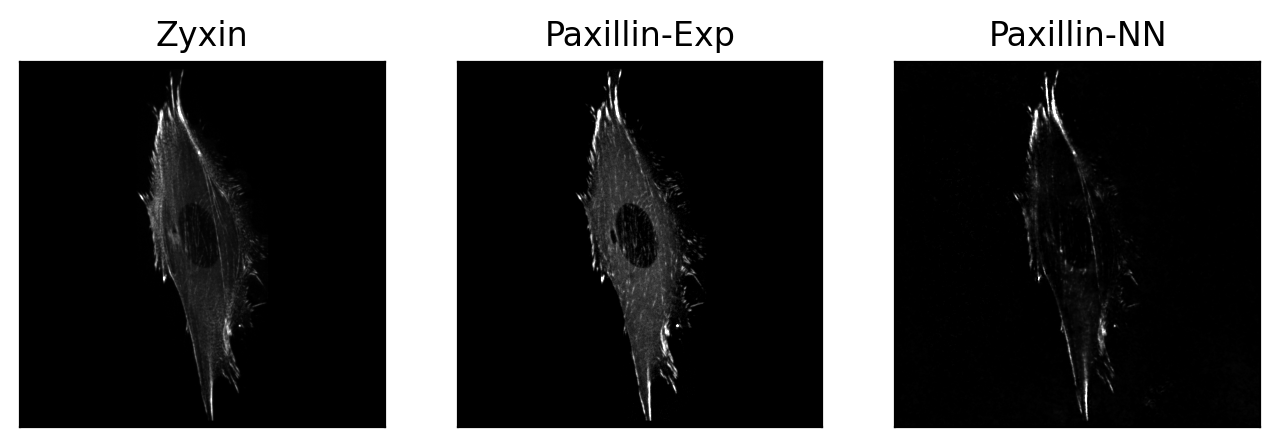

In [37]:
fig,ax=plt.subplots(1,3,figsize=(8, 3*1), dpi=200)

model = models['zyxin2']

eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
eval_dataset_kwargs['exclude_frames'] = None
dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

cell = 'cell_1'
frame = 0


idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


sample = dataset_eval[idx] # get item

input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
print(input_image.shape)

pred = model(input_image).detach().cpu().numpy()

print(pred.shape)


ax[0].set_title('Zyxin')
ax[0].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=10, vmin=0)

ax[1].set_title('Paxillin-Exp')
ax[1].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=10, vmin=0)

ax[2].set_title('Paxillin-NN')
ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='gray', vmax=5, vmin=0)

for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

# Performance on test cell
## It seems to underpredict quite dramatically, but we don't necessarily expect great generalization because the network was trained on an extremely small dataset (~180 frames).

torch.Size([1, 1, 960, 960])
(1, 2, 960, 960)


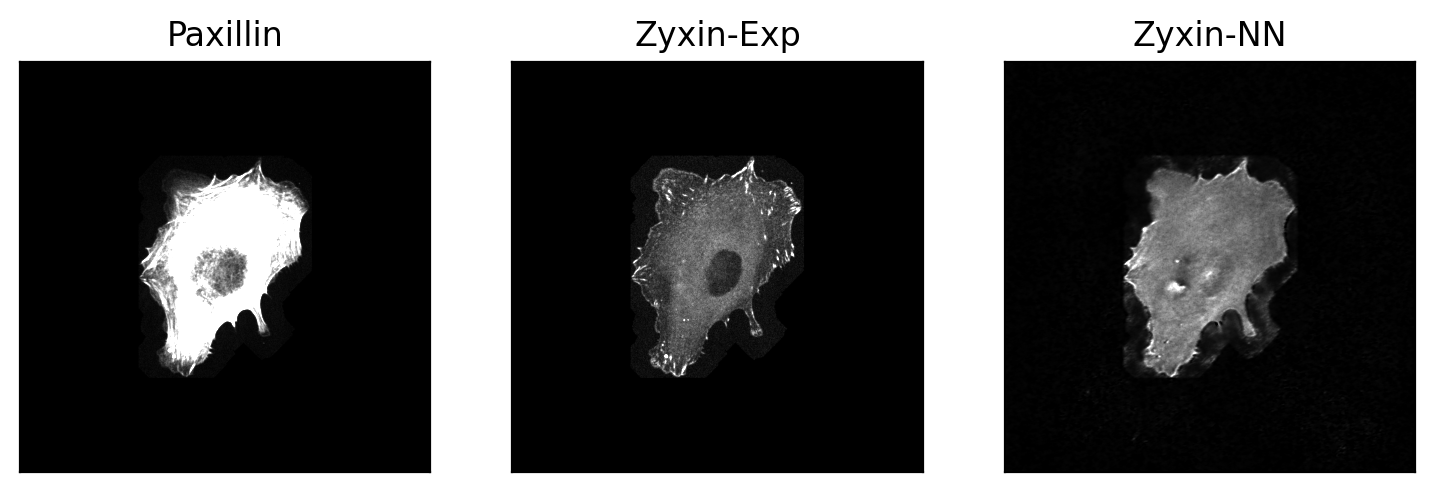

In [25]:
fig,ax=plt.subplots(1,3,figsize=(3*3, 3*1), dpi=200)

model = models['actin1']

eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 960
eval_dataset_kwargs['exclude_frames'] = None
dataset_eval = dp.CellDataset( **eval_dataset_kwargs )

cell = 'cell_1'
frame = 100

idx = dataset_eval.info.index[(dataset_eval.info.folder==cell)&(dataset_eval.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.


sample = dataset_eval[idx] # get item

input_image = model.select_inputs(model.input_type, sample).unsqueeze(0).to(device)
print(input_image.shape)

pred = model(input_image).detach().cpu().numpy()

print(pred.shape)

ax[0].set_title('Paxillin')
ax[0].imshow(sample['actin'].squeeze(), origin='lower', cmap='gray', vmax=10, vmin=0)

ax[1].set_title('Zyxin-Exp')
ax[1].imshow(sample['zyxin'].squeeze(), origin='lower', cmap='gray', vmax=300, vmin=0)

ax[2].set_title('Zyxin-NN')
ax[2].imshow(pred.squeeze()[0], origin='lower', cmap='gray', vmax=1000, vmin=0)


for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])